In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize Tagger

In [2]:
from tagger import Tagger
tagger = Tagger()

### Load Model and Data

In [3]:
model_path = '/dfs/scratch0/chami/metal/logs/2019_02_20/COLA_23_41_22/'
task_name = 'COLA'
split = 'dev'
filepath = f'{task_name}_{split}_error_analysis.tsv'

In [7]:
# Load model and data
model, dl = load_data_and_model(model_path,task_name,split)

# Create DataFrame of Raw Data, Predictions, and Labels
print('Creating dataframe')
df_error = create_dataframe(task_name, model, dl)
print('Created dataframe')

# Save (and reload) DataFrame
csv_path = '/'.join(model_path.split('/')[0:-1])
save_dataframe(df_error, filepath)

Using random seed: 619063
Loading COLA Dataset



Creating dataframe


1043it [00:15, 67.76it/s]


Created dataframe
Saved dataframe to:  COLA_dev_error_analysis.tsv


In [8]:
df_error = load_dataframe(filepath)

In [9]:
df_error.head()

,Unnamed: 0,sentence1,sentence2,score,label,uid,pred,is_wrong
0,0,the sailors rode the breeze clear of the rock...,NaN,0.988580,1,CoLA/dev.tsv:1,1,False
1,1,the weights made the rope stretch over the pu...,NaN,0.989641,1,CoLA/dev.tsv:2,1,False
2,2,the mechanical doll wr ##ig ##gled itself loo...,NaN,0.015266,1,CoLA/dev.tsv:3,0,True
3,3,"if you had eaten more , you would want less .",NaN,0.987917,1,CoLA/dev.tsv:4,1,False
4,4,"as you eat the most , you want the least .",NaN,0.042676,0,CoLA/dev.tsv:5,0,False


## Sandbox for Error Analysis

**0. Some basic statistics.**

Confusion Matrix and Performance Metrics

In [10]:
from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()
confusion_matrix(Y_gold, Y_preds, pretty_print=True, normalize=True)
print()

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")

        y=1    y=2   
 l=1  *0.866  0.134  
 l=2   0.243 *0.757  

Accuracy: 0.835
Precision: 0.866
Recall: 0.902
F1: 0.883


Plotting Predictions and Predicted Probabilistic Label Distribution

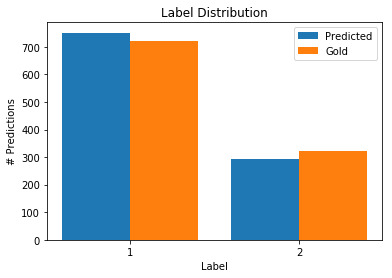

Accuracy:  0.835091083413231


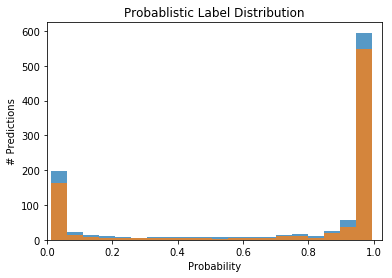

In [11]:
from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_histogram
    )
plot_predictions_histogram(Y_preds, Y_gold, title="Label Distribution")
plot_calibration_histogram(Y_probs, Y_gold, title="Probablistic Label Distribution", legend=[])

**1. We want to look at examples that are "barely" wrong and "barely" right since we have hope for boosts here.**

In [92]:
tagger.add_tag("CoLA/dev.tsv:650", 'questionable_label')
#tokenization
#grammar_mistake
#one_word
#extra_words
#questionable_label
#switch_words

Added 1 tag. Tag set 'questionable_label' contains 12 tags.


In [73]:
# print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
# print_systematic_wrong(df_error,n=10)

In [89]:
print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0.85, n=15)

VERY WRONG
121 matches were found with the given criteria.

UID:  CoLA/dev.tsv:60
sentence1: 	 i know which book mag read , and which book bob said that you hadn ' t . 
sentence2: 	nan
score: 	0.0222
label: 	1

UID:  CoLA/dev.tsv:1001
sentence1: 	 the election of john president surprised me . 
sentence2: 	nan
score: 	0.9844
label: 	0

UID:  CoLA/dev.tsv:267
sentence1: 	 it is a golden hair . 
sentence2: 	nan
score: 	0.0502
label: 	1

UID:  CoLA/dev.tsv:647
sentence1: 	 i no more could have stolen that steak than jack the diamonds . 
sentence2: 	nan
score: 	0.0475
label: 	1

UID:  CoLA/dev.tsv:632
sentence1: 	 chocolate eggs were hidden from each other by the children . 
sentence2: 	nan
score: 	0.9837
label: 	0

UID:  CoLA/dev.tsv:3
sentence1: 	 the mechanical doll wr ##ig ##gled itself loose . 
sentence2: 	nan
score: 	0.0153
label: 	1

UID:  CoLA/dev.tsv:604
sentence1: 	 the administration has issued a statement that it is willing to meet a student group , but i ' m not sure which one 

In [59]:
# print("\033[1mBARELY WRONG\033[0;0m")
# print_barely_wrong(df_error, thresh=0.05, n=5)

BARELY WRONG
9 matches were found with the given criteria.

UID:  CoLA/dev.tsv:552
sentence1: 	 she doesn ' t meet anyone for dinner , but they can ' t figure out who . 
sentence2: 	nan
score: 	0.5274
label: 	0

UID:  CoLA/dev.tsv:927
sentence1: 	 the cat were bitten by the dog . 
sentence2: 	nan
score: 	0.5138
label: 	0

UID:  CoLA/dev.tsv:655
sentence1: 	 harry told sue that albania is a lovely place for a vacation , and tom . 
sentence2: 	nan
score: 	0.4844
label: 	1

UID:  CoLA/dev.tsv:99
sentence1: 	 do you believe the claim that somebody was looking for something ? 
sentence2: 	nan
score: 	0.4543
label: 	1

UID:  CoLA/dev.tsv:927
sentence1: 	 the cat were bitten by the dog . 
sentence2: 	nan
score: 	0.5138
label: 	0



In [20]:
# print("\033[1mBARELY RIGHT\033[0;0m")
# print_barely_right(df_error, thresh=0.05, n=10)

BARELY RIGHT
7 matches were found with the given criteria.

UID:  CoLA/dev.tsv:575
sentence1: 	 she talked to harry , but i don ' t know who else . 
sentence2: 	nan
score: 	0.5353
label: 	1

UID:  CoLA/dev.tsv:575
sentence1: 	 she talked to harry , but i don ' t know who else . 
sentence2: 	nan
score: 	0.5353
label: 	1

UID:  CoLA/dev.tsv:465
sentence1: 	 you should sit before there . 
sentence2: 	nan
score: 	0.4808
label: 	0

UID:  CoLA/dev.tsv:816
sentence1: 	 the bird give the worm a tug . 
sentence2: 	nan
score: 	0.4934
label: 	0

UID:  CoLA/dev.tsv:465
sentence1: 	 you should sit before there . 
sentence2: 	nan
score: 	0.4808
label: 	0

UID:  CoLA/dev.tsv:1032
sentence1: 	 i presented bill with it to read . 
sentence2: 	nan
score: 	0.4845
label: 	0

UID:  CoLA/dev.tsv:636
sentence1: 	 chocolate eggs were hidden from every child by his mother . 
sentence2: 	nan
score: 	0.5261
label: 	1



**2. We also want to look at examples we got completely wrong since that could point to a systematic bias in the data/model. It could also help us find examples in the dataset that are mislabeled by human annotators**

In [12]:
print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0.9, n=30)

VERY WRONG
69 matches were found with the given criteria.

UID:  RTE/dev.tsv:125
sentence1: 	 a plane crashed in north carolina last year and most of the blink - 182 group was in there . the only survivors of the crash were dj am and musical partner travis barker . less lucky , " lil " chris baker , barker ' s close friend and assistant , the blink - 182 drummer ' s bodyguard , charles " che " still , the pilot and co - pilot died . both am and barker suffered many in ##jure ##s , bad burns and they needed to stay in hospital for several weeks . now am asks $ 20 million in compensation for injuries he suffered . he lawsuits against plane maker lear ##jet and wants to gain $ 10 million for medical damages , lost earnings and profit and the same amount for mental and physical suffering . 
sentence2: 	 travis barker belongs to a band . 
score: 	0.0288
label: 	1

UID:  RTE/dev.tsv:186
sentence1: 	 he said that " there is evidence that cr ##ist ##iani was involved in the murder of the six j

In [13]:
print("\033[1mVERY RIGHT\033[0;0m")
print_very_right(df_error, thresh=0.9, n=3)

VERY RIGHT
188 matches were found with the given criteria.

UID:  RTE/dev.tsv:143
sentence1: 	 a cat ##ac ##ly ##sm ##ic star ##qua ##ke is thought to have caused a flare of radiation that ripped past the earth on december 27 , batter ##ing instruments on satellites and lighting up our atmosphere . 
sentence2: 	 the flash of radiation on december 27 , lit up the earth ' s atmosphere . 
score: 	0.9977
label: 	1

UID:  RTE/dev.tsv:128
sentence1: 	 confident that those grading papers would understand answers written in text - speak , ha ##que stressed that in some exams , including english , text abbreviation ##s would be penal ##ized . 
sentence2: 	 ha ##que wants to include english in some exams . 
score: 	0.0115
label: 	0

UID:  RTE/dev.tsv:71
sentence1: 	 gi ##ulia ##na sg ##ren ##a was freed from captivity in iraq today . the italian journalist was abducted in baghdad exactly a month ago while she had been reporting for il manifesto . the islamic jihad organisation had taken her host

**3. To find systematic errors, we can also look for correlations between certain features and the incorrectness a la Socratic**


We can make this way more sophisticated by perhaps using embeddings instead of this simple [BoW featurization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [14]:
print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
for i in range(3):
    print_systematic_wrong(df_error)

SYSTEMATIC EXAMPLES
award winning
supreme court said
foreign minister


/dfs/scratch0/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


22 year old
mark antony

8 matches were found with the given criteria.

UID:  RTE/dev.tsv:77
sentence1: 	 a closely divided u . s . supreme court said on thursday its 2002 ruling that ju ##ries and not judges must impose a death sentence applies only to future cases , a decision that may affect more than 100 death row inmates . 
sentence2: 	 the supreme court decided that only judges can impose the death sentence . 
score: 	0.9890
label: 	0

award winning
court said
new government
22 year old
patti nson

8 matches were found with the given criteria.

UID:  RTE/dev.tsv:220
sentence1: 	 egypt on thursday strongly criticized israeli new foreign minister av ##ig ##dor lie ##berman for his remarks that he refused to recognize the peace efforts initiated in 2007 in the u . s . city of annapolis to restore the peace talks with the palestinians , reported the state men ##a news agency . lie ##berman ' s remarks is " regret ##table , " egyptian foreign ministry spokesman ho ##ssa ##m za ##ki wa

# BH LFs

In [30]:
from metal.mmtl.debugging.utils import print_row, apply_lfs_to_df, view_matches
from metal.mmtl.debugging.lf_helpers import regex_present

In [42]:
def LF_accuse(row):
    return 2 if regex_present(row, "accuse") else 0

lfs = [
    LF_accuse,
]

In [45]:
L, Y = apply_lfs_to_df(df_error, lfs)
view_matches(df_error, lfs[0], n=5)

Displaying 5/9 matches

sentence1: 	 he said that " there is evidence that cr ##ist ##iani was involved in the murder of the six jesuit priests " which occurred on 16 november in san salvador . 
sentence2: 	 cr ##ist ##iani is accused of the assassination of six jesuits . 
score: 	0.0042
label: 	1

sentence1: 	 the court in anger ##s handed down sentences ranging from four months suspended to 28 years for , among others , phil ##ppe v . , the key accused . the court found that he , along with his son fran ##ck v . and fran ##ck ' s former spouse , patricia m . , was one the ins ##ti ##gat ##ors of a sex ring that abused 45 children , mostly in the couple ' s flat . the abuses of children aged between six months and 12 years took place in a poor and deprived area of the western french town of anger ##s . many of the defendants were poor and lived on benefits and some were mentally impaired . about 20 of them admitted to the charges , while others claimed to have never heard of a sex rin

In [44]:
from scipy.sparse import csr_matrix
from metal.analysis import lf_summary

Y_cat = convert_labels(Y, "onezero", "categorical")
lf_summary(csr_matrix(L), Y_cat)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,2.0,0.032491,0.0,0.0,5,4,0.555556


## Designing Labeling Functions

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

In [ ]:
def LF_number(idx):
    sentence1_nums = [int(s) for s in df_error['sentence1'][idx].split() if s.isdigit()]
    sentence2_nums = [int(s) for s in df_error['sentence2'][idx].split() if s.isdigit()]
    common_nums = len(set(sentence1_nums).intersection(set(sentence2_nums)))
    
    if (sentence1_nums == []) or (sentence2_nums == []):
        return 0
    
    if common_nums > 0:
        return 2
    else:
        return 1

In [ ]:
print_row(df_error.iloc[70])
print("LF_label: ", LF_number(70)-1)

print()
print()
print_row(df_error.iloc[254])
print("LF_label: ", LF_number(254)-1)

**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.

In [ ]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

from collections import Counter
def common_words(s1,s2):
    s1_set = set(Counter(s1.split()))
    s2_set = set(Counter(s2.split()))
    return len(s1_set.intersection(s2_set))/float(min(len(s1_set),len(s2_set)))

In [ ]:
def LF_words(idx):
    ratio = common_words(df_error['sentence1'][idx], df_error['sentence2'][idx])
    if ratio < 0.3:
        return 1
    if (ratio <= 1.0) and (ratio > 0.4):
        return 2
    else:
        return 0

In [ ]:
print_row(df_error.iloc[150])
print("LF_label: ", LF_words(150)-1)

print()
print()
print_row(df_error.iloc[95])
print("LF_label: ", LF_words(95)-1)

### Analyze Labeling Functions

In [ ]:
L = np.zeros((np.shape(df_error)[0],2))
for i in range(df_error.shape[0]):
    L[i,0] = LF_number(i)
    L[i,1] = LF_words(i)

Labeling Function Summary

In [ ]:
from metal.analysis import lf_summary
from scipy.sparse import csr_matrix    

L_sparse = csr_matrix(L)
lf_summary(L_sparse,Y=df_error.label+1)

In [ ]:
incorrect = set(np.where(df_error.is_wrong == True)[0])
LF1_set = set(np.where(L[:,0]-1. == df_error.label)[0])
LF2_set = set(np.where(L[:,1]-1. == df_error.label)[0])

print("Percentage Corrected by LF_num: ", 100.*len(LF1_set.intersection(incorrect))/float(len(incorrect)))
print("Percentage Corrected by LF_words: ", 100.*len(LF2_set.intersection(incorrect))/float(len(incorrect)))